# Advanced RNN Models for Toxic Comment Classification

This notebook implements and compares various RNN architectures (LSTM, GRU, Bidirectional RNNs) using different embedding techniques for the toxic comment classification task.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import os
import nltk
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score,precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
from sklearn.utils import resample


# Deep learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# For pre-trained embeddings
import gensim
from gensim.models import KeyedVectors

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load and Prepare Data

In [3]:
# Load preprocessed data
train_data = pd.read_csv('../Dataset/train_preprocessed.csv')

# Check the data
print(f"Training data shape: {train_data.shape}")
train_data.head()

Training data shape: (159571, 12)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_text,original_length,processed_length,length_reduction
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made my username hardcore me...,264,202,23.484848
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww ! he match background colour im seemingly...,112,86,23.214286
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man , im really not trying edit war . guy ...",233,165,29.184549
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,i cant make real suggestion improvement i wond...,622,406,34.726688
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you , sir , my hero . chance you remember page...",67,54,19.402985


In [4]:
# Define the features and target labels
X = train_data['processed_text']  # Use the preprocessed text
y = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Handle missing values
X = X.fillna("")  # Replace NaN values with empty strings
y = y.fillna(0)   # Replace any missing target values with 0

# Split the data into training, validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y['toxic']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.11, random_state=42, stratify=y_temp['toxic']
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 127815
Validation set size: 15798
Test set size: 15958


In [77]:
def oversample_minority_classes(X_train, y_train):
    """Oversample minority classes to improve balance"""
    
    # Original data
    original_X = X_train.copy()
    original_y = y_train.copy()
    augmented_X = []
    augmented_y = []
    
    # Identify and oversample each rare class with increased multipliers
    multipliers = {
        'threat': 5,
        'identity_hate': 3,
        'severe_toxic': 3
    }
    
    for label, multiplier in multipliers.items():
        pos_indices = y_train[y_train[label] == 1].index
        pos_X = X_train.loc[pos_indices]
        pos_y = y_train.loc[pos_indices]
        
        for _ in range(multiplier - 1):
            augmented_X.append(pos_X)
            augmented_y.append(pos_y)
    
    # Combine with original data
    augmented_X = pd.concat([original_X] + augmented_X)
    augmented_y = pd.concat([original_y] + augmented_y)
    
    return augmented_X.reset_index(drop=True), augmented_y.reset_index(drop=True)

print("Class distribution BEFORE oversampling:")
for col in y_train.columns:
    print(f"{col}: {y_train[col].mean():.4f} ({y_train[col].sum()} samples)")

# Apply augmentation
X_train_aug, y_train_aug = oversample_minority_classes(X_train, y_train)

# Check distribution after oversampling
print("\nClass distribution AFTER oversampling:")
for col in y_train_aug.columns:
    print(f"{col}: {y_train_aug[col].mean():.4f} ({y_train_aug[col].sum()} samples)")


Class distribution BEFORE oversampling:
toxic: 0.0958 (12251 samples)
severe_toxic: 0.0099 (1262 samples)
obscene: 0.0530 (6769 samples)
threat: 0.0029 (374 samples)
insult: 0.0494 (6308 samples)
identity_hate: 0.0086 (1100 samples)

Class distribution AFTER oversampling:
toxic: 0.1358 (18199 samples)
severe_toxic: 0.0346 (4634 samples)
obscene: 0.0875 (11723 samples)
threat: 0.0164 (2202 samples)
insult: 0.0841 (11274 samples)
identity_hate: 0.0306 (4108 samples)


## 2. Text Preprocessing for Deep Learning

In [5]:
# Download necessary NLTK resources if not already downloaded
nltk.download('punkt', quiet=True)

True

In [6]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.itos = {0: "<PAD>", 1: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<UNK>": 1}
        self.freq_threshold = freq_threshold
        
    def __len__(self):
        return len(self.itos)
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 2  # Start from 2 as 0 and 1 are reserved for PAD and UNK
        
        for sentence in tqdm(sentence_list, desc="Building vocabulary"):
            for word in nltk.word_tokenize(sentence.lower()):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        tokenized_text = nltk.word_tokenize(text.lower())
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]

In [7]:
# Build vocabulary from training data
vocab = Vocabulary(freq_threshold=2)
vocab.build_vocabulary(X_train.values)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Building vocabulary:   0%|          | 0/127815 [00:00<?, ?it/s]

Vocabulary size: 72577


In [8]:
class ToxicCommentDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X = X
        self.y = y
        self.vocab = vocab
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        text = self.X.iloc[index]
        labels = torch.FloatTensor(self.y.iloc[index].values)
        
        # Convert text to numerical form
        numericalized_text = self.vocab.numericalize(text)
        return torch.LongTensor(numericalized_text), labels

In [9]:
# Pad sequences in a batch to the same length
def collate_batch(batch):
    text_list, label_list = [], []
    
    for text, label in batch:
        text_list.append(text)
        label_list.append(label)
    
    # Pad sequences
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    labels = torch.stack(label_list)
    
    return text_list, labels

In [61]:
# Create datasets
BATCH_SIZE = 32

train_dataset = ToxicCommentDataset(X_train, y_train, vocab)
train_augmented_dataset = ToxicCommentDataset(X_train_aug, y_train_aug, vocab)
val_dataset = ToxicCommentDataset(X_val, y_val, vocab)
test_dataset = ToxicCommentDataset(X_test, y_test, vocab)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    collate_fn=collate_batch,
    num_workers=16
)
train_augmented_loader = DataLoader(
    train_augmented_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    collate_fn=collate_batch,
    num_workers=16
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    collate_fn=collate_batch,
    num_workers=16
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    collate_fn=collate_batch,
    num_workers=16
)

## 3. Build RNN Models

In [11]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        
        # If bidirectional, multiply by 2 as we'll have hidden states from both directions
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text shape: [batch size, sentence length]
        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch size, sentence length, embedding dim]
        
        output, (hidden, cell) = self.lstm(embedded)
        # output shape: [batch size, sentence length, hidden dim * num directions]
        # hidden shape: [num layers * num directions, batch size, hidden dim]
        
        if self.lstm.bidirectional:
            # Concatenate the final forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        # hidden shape: [batch size, hidden dim * num directions]
        
        return torch.sigmoid(self.fc(self.dropout(hidden)))

In [12]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          bidirectional=bidirectional, 
                          dropout=dropout if n_layers > 1 else 0,
                          batch_first=True)
        
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        
        if self.gru.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
            
        return torch.sigmoid(self.fc(self.dropout(hidden)))

In [13]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Linear(hidden_dim, 1)
        
    def forward(self, lstm_output):
        # lstm_output shape: [batch_size, seq_len, hidden_dim]
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        # attention_weights shape: [batch_size, seq_len, 1]
        
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        # context_vector shape: [batch_size, hidden_dim]
        
        return context_vector, attention_weights

In [14]:
class AttentionBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=True, 
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        
        self.attention = AttentionLayer(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        outputs, _ = self.lstm(embedded)
        # outputs shape: [batch_size, seq_len, hidden_dim * 2]
        
        context, attention_weights = self.attention(outputs)
        # context shape: [batch_size, hidden_dim * 2]
        
        return torch.sigmoid(self.fc(self.dropout(context)))

## 4. Train and Evaluate Function

In [26]:

# Calculate class weights
class_weights = {}
for col in y_train.columns:
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train[col]
    )
    class_weights[col] = torch.FloatTensor(weights).to(device)

# Define weighted loss function
def weighted_binary_cross_entropy(output, target, weights=None):
    column_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    
    if weights is None:
        weights = {}
        for col in column_names:
            weights[col] = torch.ones([2]).to(output.device)
    
    loss = 0
    for i, col in enumerate(column_names):
        if col in weights:
            class_weight = weights[col]
        else:
            class_weight = torch.ones([2]).to(output.device)
            
        loss_per_sample = F.binary_cross_entropy(
            output[:, i],
            target[:, i],
            reduction='none'
        )
        weight_per_sample = class_weight[1] * target[:, i] + class_weight[0] * (1 - target[:, i])
        loss += (loss_per_sample * weight_per_sample).mean()
    
    return loss / target.shape[1]

In [30]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        """
        alpha: List of class weights, should match the number of classes
        gamma: Focusing parameter (higher = more focus on hard examples)
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weight for each class
        self.gamma = gamma  # Focusing parameter
        self.epsilon = 1e-6  # For numerical stability
        
    def forward(self, inputs, targets):
        # Inputs should already be sigmoided (0-1)
        inputs = torch.clamp(inputs, self.epsilon, 1 - self.epsilon)
        
        # Calculate BCE for each class
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        
        # Calculate focal weights
        pt = torch.exp(-bce_loss)  # pt = probability of the correct class
        focal_weight = (1 - pt) ** self.gamma
        
        # Apply class weights if provided
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)
            # Get weights for each sample based on its true class
            batch_alpha = torch.ones_like(inputs).to(inputs.device)
            for i in range(len(alpha)):
                batch_alpha[:, i] = alpha[i]
            focal_weight = batch_alpha * focal_weight
        
        # Calculate weighted loss
        focal_loss = focal_weight * bce_loss
        
        return focal_loss.mean()

In [82]:

class AdaptiveFocalLoss(nn.Module):
    def __init__(self, alpha=None, class_gammas=None):
        super().__init__()
        self.alpha = alpha
        self.class_gammas = class_gammas
        self.epsilon = 1e-6
        
    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, self.epsilon, 1 - self.epsilon)
        
        # Binary cross entropy
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        
        # Different gamma for each class
        focal_loss = torch.zeros_like(bce_loss)
        class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        
        for i, col in enumerate(class_names):
            gamma = self.class_gammas.get(col, 2.0)  # Default gamma is 2.0
            pt = torch.exp(-bce_loss[:, i])
            focal_weight = (1 - pt) ** gamma
            
            # Apply class weights if provided
            if self.alpha is not None:
                focal_weight = focal_weight * self.alpha[i]
                
            focal_loss[:, i] = focal_weight * bce_loss[:, i]
        
        return focal_loss.mean()

In [16]:
def train_epoch(model, data_loader, optimizer, criterion, device, accumulation_steps=2):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    
    optimizer.zero_grad()
    
    for i, (texts, labels) in enumerate(tqdm(data_loader, desc="Training", leave=False)):
        texts = texts.long().to(device)
        labels = labels.to(device)
        
        predictions = model(texts)
        loss = criterion(predictions, labels) / accumulation_steps
        
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            optimizer.step()
            optimizer.zero_grad()
        
        with torch.no_grad():
            predictions = (predictions > 0.5).float()
            accuracy = ((predictions == labels).float().sum()) / (len(labels) * labels.size(1))
        
        epoch_loss += loss.item() * accumulation_steps
        epoch_accuracy += accuracy.item()
    
    return epoch_loss / len(data_loader), epoch_accuracy / len(data_loader)

In [17]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_accuracy = 0
    
    with torch.no_grad():
        for texts, labels in tqdm(data_loader, desc="Evaluating", leave=False):
            texts = texts.long().to(device)  # Convert to long before sending to device
            labels = labels.to(device)
            
            predictions = model(texts)
            loss = criterion(predictions, labels)
            
            predictions = (predictions > 0.5).float()
            accuracy = ((predictions == labels).float().sum()) / (len(labels) * labels.size(1))
            
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()
    
    return epoch_loss / len(data_loader), epoch_accuracy / len(data_loader)

In [18]:
def predict(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for texts, labels in tqdm(data_loader, desc="Predicting", leave=False):
            texts = texts.long().to(device)  # Convert to long before sending to device
            outputs = model(texts)
            
            # Convert sigmoid outputs to binary predictions
            preds = (outputs > 0.5).float().cpu().numpy()
            labels = labels.cpu().numpy()
            
            predictions.append(preds)
            actual_labels.append(labels)
    
    # Concatenate batch predictions
    predictions = np.vstack(predictions)
    actual_labels = np.vstack(actual_labels)
    
    return predictions, actual_labels

In [50]:
def find_optimal_thresholds(model, val_loader, device):
    """Find optimal thresholds using validation data only"""
    model.eval()
    all_outputs = []
    all_labels = []
    
    # Collect validation predictions
    with torch.no_grad():
        for texts, labels in tqdm(val_loader, desc="Finding thresholds", leave=False):
            texts = texts.long().to(device)
            outputs = model(texts).cpu().numpy()
            all_outputs.append(outputs)
            all_labels.append(labels.cpu().numpy())
    
    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)
    
    # Find optimal threshold for each class using VALIDATION data
    thresholds = []
    for i in range(all_outputs.shape[1]):
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in np.arange(0.1, 0.9, 0.05):
            preds = (all_outputs[:, i] > threshold).astype(float)
            f1 = f1_score(all_labels[:, i], preds)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        thresholds.append(best_threshold)
    
    print(f"Optimal thresholds found on validation: {thresholds}")
    return thresholds

def predict_with_thresholds(model, data_loader, thresholds, device):
    """Apply pre-determined thresholds to make predictions"""
    model.eval()
    all_outputs = []
    all_labels = []
    
    # Collect test predictions
    with torch.no_grad():
        for texts, labels in tqdm(data_loader, desc="Predicting", leave=False):
            texts = texts.long().to(device)
            outputs = model(texts).cpu().numpy()
            all_outputs.append(outputs)
            all_labels.append(labels.cpu().numpy())
    
    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)
    
    # Apply the pre-determined thresholds
    predictions = np.zeros_like(all_outputs)
    for i in range(all_outputs.shape[1]):
        predictions[:, i] = (all_outputs[:, i] > thresholds[i]).astype(float)
    
    return predictions, all_labels

In [47]:
def detailed_evaluation_table(predictions, actual_labels, label_names):
    """Generate a detailed evaluation table using pandas DataFrame"""
    
    results = []
    
    for i, column in enumerate(label_names):
        # Calculate metrics
        precision = precision_score(actual_labels[:, i], predictions[:, i])
        recall = recall_score(actual_labels[:, i], predictions[:, i])
        f1 = f1_score(actual_labels[:, i], predictions[:, i])
        
        # Calculate confusion matrix elements
        tp = ((predictions[:, i] == 1) & (actual_labels[:, i] == 1)).sum()
        fp = ((predictions[:, i] == 1) & (actual_labels[:, i] == 0)).sum()
        fn = ((predictions[:, i] == 0) & (actual_labels[:, i] == 1)).sum()
        tn = ((predictions[:, i] == 0) & (actual_labels[:, i] == 0)).sum()
        
        # Calculate additional metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        prevalence = (tp + fn) / (tp + tn + fp + fn)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # Store results
        results.append({
            'Category': column,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Accuracy': accuracy,
            'Prevalence': prevalence,
            'Specificity': specificity,
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'TN': tn
        })
    
    # Create DataFrame and format
    df = pd.DataFrame(results)
    
    # Format metrics as percentages
    for col in ['Precision', 'Recall', 'F1', 'Accuracy', 'Prevalence', 'Specificity']:
        df[col] = df[col].map('{:.2%}'.format)
    
    return df



In [19]:
def model_performance_metrics(predictions, actual_labels, label_names):
    results = {}
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(actual_labels, predictions)
    results['accuracy'] = accuracy
    
    # Calculate F1 scores for each class
    f1_scores = []
    for i, column in enumerate(label_names):
        f1 = f1_score(actual_labels[:, i], predictions[:, i])
        f1_scores.append(f1)
        results[f'f1_{column}'] = f1
    
    # Calculate macro and micro F1
    macro_f1 = np.mean(f1_scores)
    micro_f1 = f1_score(actual_labels, predictions, average='micro')
    results['macro_f1'] = macro_f1
    results['micro_f1'] = micro_f1
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    
    print("\nF1 scores by toxicity type:")
    for i, column in enumerate(label_names):
        print(f"{column}: {f1_scores[i]:.4f}")
        
    return results

In [121]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, n_epochs=10, patience=3):
    best_val_loss = float('inf')
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # Early stopping variables
    counter = 0
    early_stop = False
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        end_time = time.time()
        epoch_mins = (end_time - start_time) // 60
        epoch_secs = (end_time - start_time) % 60
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '../models/best_rnn_model.pt')
            print(f"\t[Saved best model with val_loss: {val_loss:.4f}]")
            # Reset counter when validation loss improves
            counter = 0
        else:
            counter += 1
            print(f'\t[EarlyStopping counter: {counter}/{patience}]')
            if counter >= patience:
                print(f'\t[Early stopping triggered after {epoch+1} epochs]')
                early_stop = True
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.1f}s')
        print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tVal. Loss: {val_loss:.4f} | Val. Acc: {val_acc*100:.2f}%')
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        if early_stop:
            print("Training stopped early due to no improvement in validation loss")
            break
    
    return train_losses, train_accs, val_losses, val_accs

In [21]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs, model_name):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'../results/{model_name.lower().replace(" ", "_")}_training_history.png')
    plt.show()

## 5. Train and Evaluate LSTM Model

In [122]:
# LSTM Model Hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 6  # Six toxicity categories
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
PAD_IDX = 0
LEARNING_RATE = 0.001
N_EPOCHS = 10

In [123]:
# Initialize LSTM Model
lstm_model = LSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
)

# Move model to device (GPU/CPU)
lstm_model = lstm_model.to(device)
print(lstm_model)

LSTMClassifier(
  (embedding): Embedding(72577, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [124]:
# Define optimizer and loss function
optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

# Create weights based on class distribution
class_dist = np.array([y_train[col].mean() for col in y_train.columns])
print(f"Class distribution: {class_dist}")
class_weights = 1 / (class_dist + 0.01)  # Add small epsilon to avoid division by zero
class_weights = class_weights / class_weights.sum() * len(class_weights)  # Normalize weights

# Adjust class weights for rare classes
class_weights[3] *= 30  # Quintuple weight for threat
class_weights[5] *= 8  # Quintuple weight for identity_hate
class_weights[1] *= 8  # Quintuple weight for severe_toxic

print(f"Class weights: {class_weights}")

class_gammas = {
    'toxic': 1.0,
    'severe_toxic': 1.5, 
    'obscene': 1.0,
    'threat': 1.5,       # Reduced from 6.0
    'insult': 1.0,
    'identity_hate': 2.0 # Reduced from 4.0
}

# Create the focal loss
criterion = AdaptiveFocalLoss(alpha=torch.FloatTensor(class_weights), class_gammas=class_gammas).to(device)


Class distribution: [0.09584947 0.00987365 0.05295936 0.0029261  0.04935258 0.00860619]
Class weights: [ 0.25350136 10.80143425  0.42619535 62.27626853  0.45209466 11.53722987]


In [125]:


# Train the model
lstm_train_losses, lstm_train_accs, lstm_val_losses, lstm_val_accs = train_model(
    lstm_model, train_augmented_loader, val_loader, criterion, optimizer, device, N_EPOCHS, patience=3 
)

Training:   0%|          | 0/4092 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[Saved best model with val_loss: 0.1124]
Epoch: 01 | Time: 5.0m 59.7s
	Train Loss: 0.2259 | Train Acc: 96.19%
	Val. Loss: 0.1124 | Val. Acc: 97.51%


Training:   0%|          | 0/4092 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[Saved best model with val_loss: 0.0954]
Epoch: 02 | Time: 6.0m 25.8s
	Train Loss: 0.1220 | Train Acc: 97.09%
	Val. Loss: 0.0954 | Val. Acc: 97.83%


Training:   0%|          | 0/4092 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[EarlyStopping counter: 1/3]
Epoch: 03 | Time: 6.0m 27.6s
	Train Loss: 0.0869 | Train Acc: 97.41%
	Val. Loss: 0.1053 | Val. Acc: 98.00%


Training:   0%|          | 0/4092 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[EarlyStopping counter: 2/3]
Epoch: 04 | Time: 6.0m 20.2s
	Train Loss: 0.0698 | Train Acc: 97.56%
	Val. Loss: 0.1124 | Val. Acc: 97.98%


Training:   0%|          | 0/4092 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[EarlyStopping counter: 3/3]
	[Early stopping triggered after 5 epochs]
Epoch: 05 | Time: 6.0m 23.9s
	Train Loss: 0.0591 | Train Acc: 97.72%
	Val. Loss: 0.1206 | Val. Acc: 98.07%
Training stopped early due to no improvement in validation loss


In [126]:
def test_loss_values():
    # Get a batch of data
    for texts, labels in val_loader:
        texts = texts.long().to(device)
        labels = labels.to(device)
        break
    
    # Get model predictions
    with torch.no_grad():
        outputs = lstm_model(texts)
    
    # Compare different loss functions
    bce_loss = F.binary_cross_entropy(outputs, labels)
    weighted_bce = weighted_binary_cross_entropy(outputs, labels, weights=class_weights)
    standard_focal = FocalLoss(alpha=torch.FloatTensor(class_weights)).to(device)(outputs, labels)
    adaptive_focal = AdaptiveFocalLoss(alpha=torch.FloatTensor(class_weights), 
                                     class_gammas=class_gammas).to(device)(outputs, labels)
    
    print(f"Standard BCE Loss: {bce_loss.item():.4f}")
    print(f"Weighted BCE Loss: {weighted_bce.item():.4f}")
    print(f"Standard Focal Loss: {standard_focal.item():.4f}")
    print(f"Adaptive Focal Loss: {adaptive_focal.item():.4f}")
    
    return bce_loss.item(), weighted_bce.item(), standard_focal.item(), adaptive_focal.item()

# Run the test
test_loss_values()

Standard BCE Loss: 0.0747
Weighted BCE Loss: 0.0747
Standard Focal Loss: 0.0071
Adaptive Focal Loss: 0.0110


(0.0747310221195221,
 0.07473102957010269,
 0.007073467131704092,
 0.011009862646460533)

In [127]:
# Load the best model
lstm_model.load_state_dict(torch.load('../models/best_rnn_model.pt'))
lstm_model.eval()

# Find optimal thresholds on validation data
optimal_thresholds = find_optimal_thresholds(lstm_model, val_loader, device)

# Apply these thresholds on the test set
lstm_preds, lstm_actual = predict_with_thresholds(lstm_model, test_loader, optimal_thresholds, device)

# Evaluate using the test set with validation-determined thresholds
print("\n============ BiLSTM Model Evaluation ============")
lstm_results = model_performance_metrics(lstm_preds, lstm_actual, y.columns)

# Detailed evaluation
df_evaluation = detailed_evaluation_table(lstm_preds, lstm_actual, y.columns)


# To sort by F1 score:
df_sorted = df_evaluation.sort_values('F1', ascending=False)
display(df_sorted)

Finding thresholds:   0%|          | 0/494 [00:00<?, ?it/s]

Optimal thresholds found on validation: [0.3500000000000001, 0.45000000000000007, 0.3500000000000001, 0.6000000000000002, 0.3500000000000001, 0.40000000000000013]


Predicting:   0%|          | 0/499 [00:00<?, ?it/s]


============ BiLSTM Model Evaluation ============
Accuracy: 0.9049
Macro F1: 0.5533
Micro F1: 0.6597

F1 scores by toxicity type:
toxic: 0.6706
severe_toxic: 0.5234
obscene: 0.7412
threat: 0.3333
insult: 0.6502
identity_hate: 0.4014


,Category,Precision,Recall,F1,Accuracy,Prevalence,Specificity,TP,FP,FN,TN
2,obscene,78.14%,70.48%,74.12%,97.39%,5.31%,98.89%,597,167,250,14944
0,toxic,77.35%,59.19%,67.06%,94.43%,9.58%,98.16%,905,265,624,14164
4,insult,67.89%,62.38%,65.02%,96.63%,5.01%,98.44%,499,236,301,14922
1,severe_toxic,44.39%,63.76%,52.34%,98.92%,0.93%,99.25%,95,119,54,15690
5,identity_hate,43.51%,37.25%,40.14%,98.93%,0.96%,99.53%,57,74,96,15731
3,threat,54.55%,24.00%,33.33%,99.70%,0.31%,99.94%,12,10,38,15898


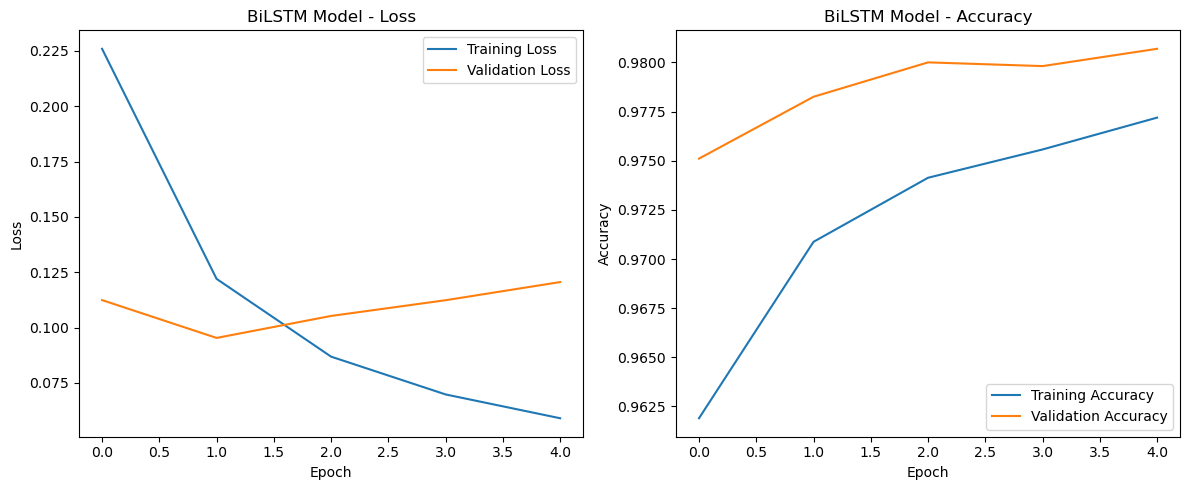

In [128]:
# Add this code before plotting and saving your training history
import os
os.makedirs('../results', exist_ok=True)
plot_training_history(
    lstm_train_losses, lstm_train_accs, lstm_val_losses, lstm_val_accs, "BiLSTM Model"
)

## 6. Train and Evaluate GRU Model

In [129]:
# Initialize GRU Model
gru_model = GRUClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
)

# Move model to device (GPU/CPU)
gru_model = gru_model.to(device)
print(gru_model)

GRUClassifier(
  (embedding): Embedding(72577, 100, padding_idx=0)
  (gru): GRU(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [130]:
# Define optimizer and loss function
optimizer = optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)

# Train the model
gru_train_losses, gru_train_accs, gru_val_losses, gru_val_accs = train_model(
    gru_model, train_loader, val_loader, criterion, optimizer, device, N_EPOCHS, patience=3
)

Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[Saved best model with val_loss: 0.0892]
Epoch: 01 | Time: 4.0m 33.9s
	Train Loss: 0.1270 | Train Acc: 97.09%
	Val. Loss: 0.0892 | Val. Acc: 97.78%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[Saved best model with val_loss: 0.0826]
Epoch: 02 | Time: 4.0m 34.5s
	Train Loss: 0.0796 | Train Acc: 97.71%
	Val. Loss: 0.0826 | Val. Acc: 97.98%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[EarlyStopping counter: 1/3]
Epoch: 03 | Time: 4.0m 34.2s
	Train Loss: 0.0643 | Train Acc: 97.88%
	Val. Loss: 0.0852 | Val. Acc: 98.08%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[EarlyStopping counter: 2/3]
Epoch: 04 | Time: 4.0m 35.3s
	Train Loss: 0.0566 | Train Acc: 97.98%
	Val. Loss: 0.0982 | Val. Acc: 98.07%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[EarlyStopping counter: 3/3]
	[Early stopping triggered after 5 epochs]
Epoch: 05 | Time: 4.0m 35.2s
	Train Loss: 0.0494 | Train Acc: 98.03%
	Val. Loss: 0.0896 | Val. Acc: 98.12%
Training stopped early due to no improvement in validation loss


In [131]:
# Save the trained GRU model
torch.save(gru_model.state_dict(), '../models/gru_model.pt')

# Find optimal thresholds on validation data
gru_optimal_thresholds = find_optimal_thresholds(gru_model, val_loader, device)

# Apply these thresholds on the test set
gru_preds, gru_actual = predict_with_thresholds(gru_model, test_loader, gru_optimal_thresholds, device)

# Evaluate using the test set with validation-determined thresholds
print("\n============ BiGRU Model Evaluation ============")
gru_results = model_performance_metrics(gru_preds, gru_actual, y.columns)

# Detailed evaluation
gru_df_evaluation = detailed_evaluation_table(gru_preds, gru_actual, y.columns)

# To sort by F1 score:
gru_df_sorted = gru_df_evaluation.sort_values('F1', ascending=False)
display(gru_df_sorted)

Finding thresholds:   0%|          | 0/494 [00:00<?, ?it/s]

Optimal thresholds found on validation: [0.3500000000000001, 0.3500000000000001, 0.45000000000000007, 0.25000000000000006, 0.40000000000000013, 0.40000000000000013]


Predicting:   0%|          | 0/499 [00:00<?, ?it/s]


============ BiGRU Model Evaluation ============
Accuracy: 0.9147
Macro F1: 0.6267
Micro F1: 0.7334

F1 scores by toxicity type:
toxic: 0.7670
severe_toxic: 0.5205
obscene: 0.8038
threat: 0.4259
insult: 0.7068
identity_hate: 0.5361


,Category,Precision,Recall,F1,Accuracy,Prevalence,Specificity,TP,FP,FN,TN
2,obscene,81.71%,79.10%,80.38%,97.95%,5.31%,99.01%,670,150,177,14961
0,toxic,80.56%,73.19%,76.70%,95.74%,9.58%,98.13%,1119,270,410,14159
4,insult,68.18%,73.38%,70.68%,96.95%,5.01%,98.19%,587,274,213,14884
5,identity_hate,49.72%,58.17%,53.61%,99.03%,0.96%,99.43%,89,90,64,15715
1,severe_toxic,46.11%,59.73%,52.05%,98.97%,0.93%,99.34%,89,104,60,15705
3,threat,39.66%,46.00%,42.59%,99.61%,0.31%,99.78%,23,35,27,15873


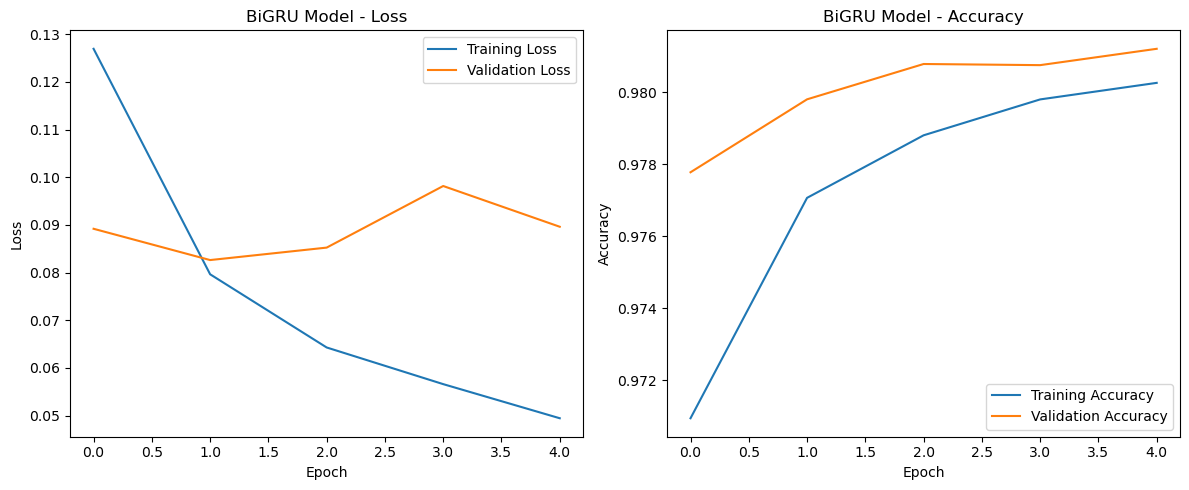

In [132]:
# Plot training history
plot_training_history(
    gru_train_losses, gru_train_accs, gru_val_losses, gru_val_accs, "BiGRU Model"
)

## 7. Train and Evaluate Attention-based BiLSTM Model

In [133]:
# Initialize Attention-based BiLSTM Model
attn_lstm_model = AttentionBiLSTM(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
)

# Move model to device (GPU/CPU)
attn_lstm_model = attn_lstm_model.to(device)
print(attn_lstm_model)

AttentionBiLSTM(
  (embedding): Embedding(72577, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): AttentionLayer(
    (attention): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [134]:
# Define optimizer and loss function
optimizer = optim.Adam(attn_lstm_model.parameters(), lr=LEARNING_RATE)

# Train the model
attn_train_losses, attn_train_accs, attn_val_losses, attn_val_accs = train_model(
    attn_lstm_model, train_loader, val_loader, criterion, optimizer, device, N_EPOCHS
)

Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[Saved best model with val_loss: 0.0989]
Epoch: 01 | Time: 6.0m 18.3s
	Train Loss: 0.1252 | Train Acc: 97.08%
	Val. Loss: 0.0989 | Val. Acc: 97.53%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[Saved best model with val_loss: 0.0779]
Epoch: 02 | Time: 6.0m 20.2s
	Train Loss: 0.0779 | Train Acc: 97.73%
	Val. Loss: 0.0779 | Val. Acc: 97.97%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[EarlyStopping counter: 1/3]
Epoch: 03 | Time: 6.0m 21.5s
	Train Loss: 0.0641 | Train Acc: 97.91%
	Val. Loss: 0.0809 | Val. Acc: 98.03%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[EarlyStopping counter: 2/3]
Epoch: 04 | Time: 6.0m 21.3s
	Train Loss: 0.0547 | Train Acc: 98.02%
	Val. Loss: 0.0804 | Val. Acc: 98.15%


Training:   0%|          | 0/3995 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/494 [00:00<?, ?it/s]

	[EarlyStopping counter: 3/3]
	[Early stopping triggered after 5 epochs]
Epoch: 05 | Time: 6.0m 23.6s
	Train Loss: 0.0468 | Train Acc: 98.11%
	Val. Loss: 0.0984 | Val. Acc: 98.14%
Training stopped early due to no improvement in validation loss


In [135]:
# Save the trained Attention-based BiLSTM model
torch.save(attn_lstm_model.state_dict(), '../models/attn_bilstm_model.pt')

# Find optimal thresholds on validation data
attn_optimal_thresholds = find_optimal_thresholds(attn_lstm_model, val_loader, device)

# Apply these thresholds on the test set
attn_preds, attn_actual = predict_with_thresholds(attn_lstm_model, test_loader, attn_optimal_thresholds, device)

# Evaluate using the test set with validation-determined thresholds
print("\n============ Attention BiLSTM Model Evaluation ============")
attn_results = model_performance_metrics(attn_preds, attn_actual, y.columns)

# Detailed evaluation
attn_df_evaluation = detailed_evaluation_table(attn_preds, attn_actual, y.columns)

# To sort by F1 score:
attn_df_sorted = attn_df_evaluation.sort_values('F1', ascending=False)
display(attn_df_sorted)

Finding thresholds:   0%|          | 0/494 [00:00<?, ?it/s]

Optimal thresholds found on validation: [0.40000000000000013, 0.40000000000000013, 0.5000000000000001, 0.25000000000000006, 0.45000000000000007, 0.3500000000000001]


Predicting:   0%|          | 0/499 [00:00<?, ?it/s]


============ Attention BiLSTM Model Evaluation ============
Accuracy: 0.9156
Macro F1: 0.6240
Micro F1: 0.7318

F1 scores by toxicity type:
toxic: 0.7753
severe_toxic: 0.5067
obscene: 0.7938
threat: 0.4565
insult: 0.7143
identity_hate: 0.4974


,Category,Precision,Recall,F1,Accuracy,Prevalence,Specificity,TP,FP,FN,TN
2,obscene,79.90%,78.87%,79.38%,97.83%,5.31%,98.89%,668,168,179,14943
0,toxic,83.70%,72.20%,77.53%,95.99%,9.58%,98.51%,1104,215,425,14214
4,insult,68.71%,74.38%,71.43%,97.02%,5.01%,98.21%,595,271,205,14887
1,severe_toxic,42.34%,63.09%,50.67%,98.85%,0.93%,99.19%,94,128,55,15681
5,identity_hate,41.20%,62.75%,49.74%,98.78%,0.96%,99.13%,96,137,57,15668
3,threat,50.00%,42.00%,45.65%,99.69%,0.31%,99.87%,21,21,29,15887


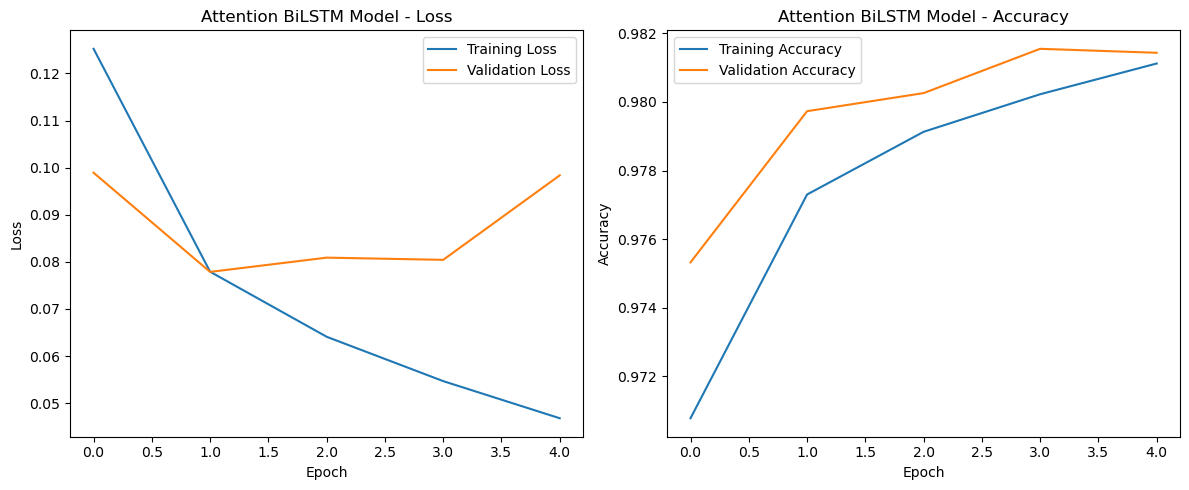

In [136]:
# Plot training history
plot_training_history(
    attn_train_losses, attn_train_accs, attn_val_losses, attn_val_accs, "Attention BiLSTM Model"
)

## 8. Compare All RNN Models with Previous Models

In [137]:
# Try to load previous results
try:
    # Load the previous results dataframe
    results_df = pd.read_pickle("../results/vectorizer_model_results.pkl")
    print("Loaded previous model results.")
except FileNotFoundError:
    print("Previous model results not found. Creating new results dataframe.")
    results_df = pd.DataFrame()

Previous model results not found. Creating new results dataframe.


In [138]:
# Add RNN model results to the dataframe
rnn_results = [
    {**lstm_results, 'model_name': 'BiLSTM'},
    {**gru_results, 'model_name': 'BiGRU'},
    {**attn_results, 'model_name': 'Attention BiLSTM'}
]

# Combine with existing results or create new dataframe
if not results_df.empty:
    rnn_df = pd.DataFrame(rnn_results)
    combined_df = pd.concat([results_df, rnn_df], ignore_index=True)
else:
    combined_df = pd.DataFrame(rnn_results)

# Save the combined results
combined_df.to_pickle("../results/all_model_results.pkl")
print("Combined model results saved.")

Combined model results saved.


In [139]:
# Display all results, sorted by macro F1 score
print("\n\n================ COMBINED RESULTS FOR ALL MODELS ================")
print(combined_df[['model_name', 'accuracy', 'macro_f1', 'micro_f1']].sort_values('macro_f1', ascending=False))



================ COMBINED RESULTS FOR ALL MODELS ================
         model_name  accuracy  macro_f1  micro_f1
1             BiGRU  0.914651  0.626691  0.733352
2  Attention BiLSTM  0.915591  0.624009  0.731763
0            BiLSTM  0.904875  0.553349  0.659659


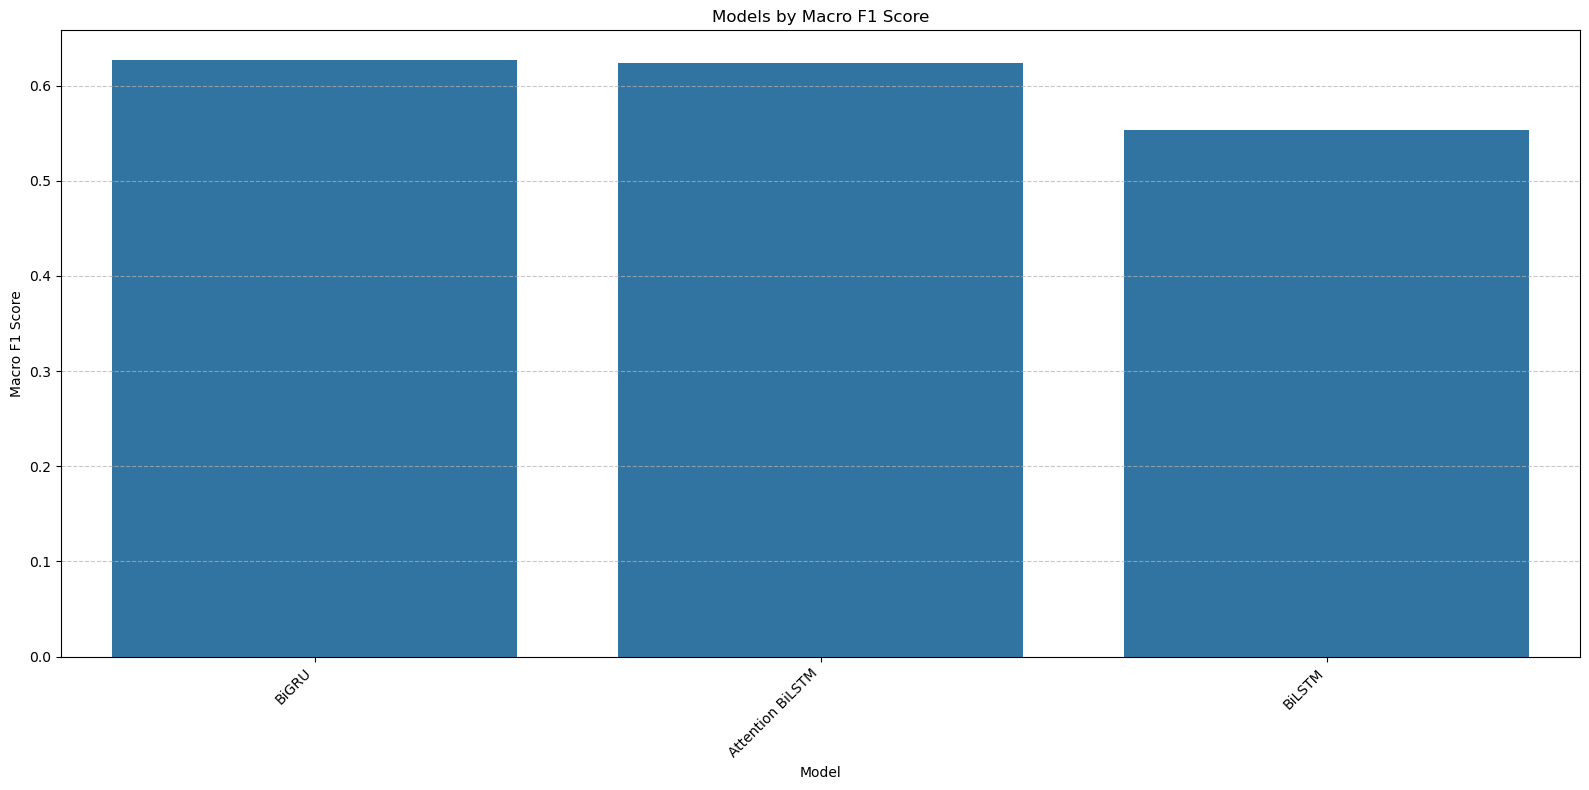

In [140]:
# Visualize results
plt.figure(figsize=(16, 8))
sns.barplot(x='model_name', y='macro_f1', data=combined_df.sort_values('macro_f1', ascending=False))
plt.title('Models by Macro F1 Score')
plt.xlabel('Model')
plt.ylabel('Macro F1 Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("../results/all_models_comparison.png")
plt.show()

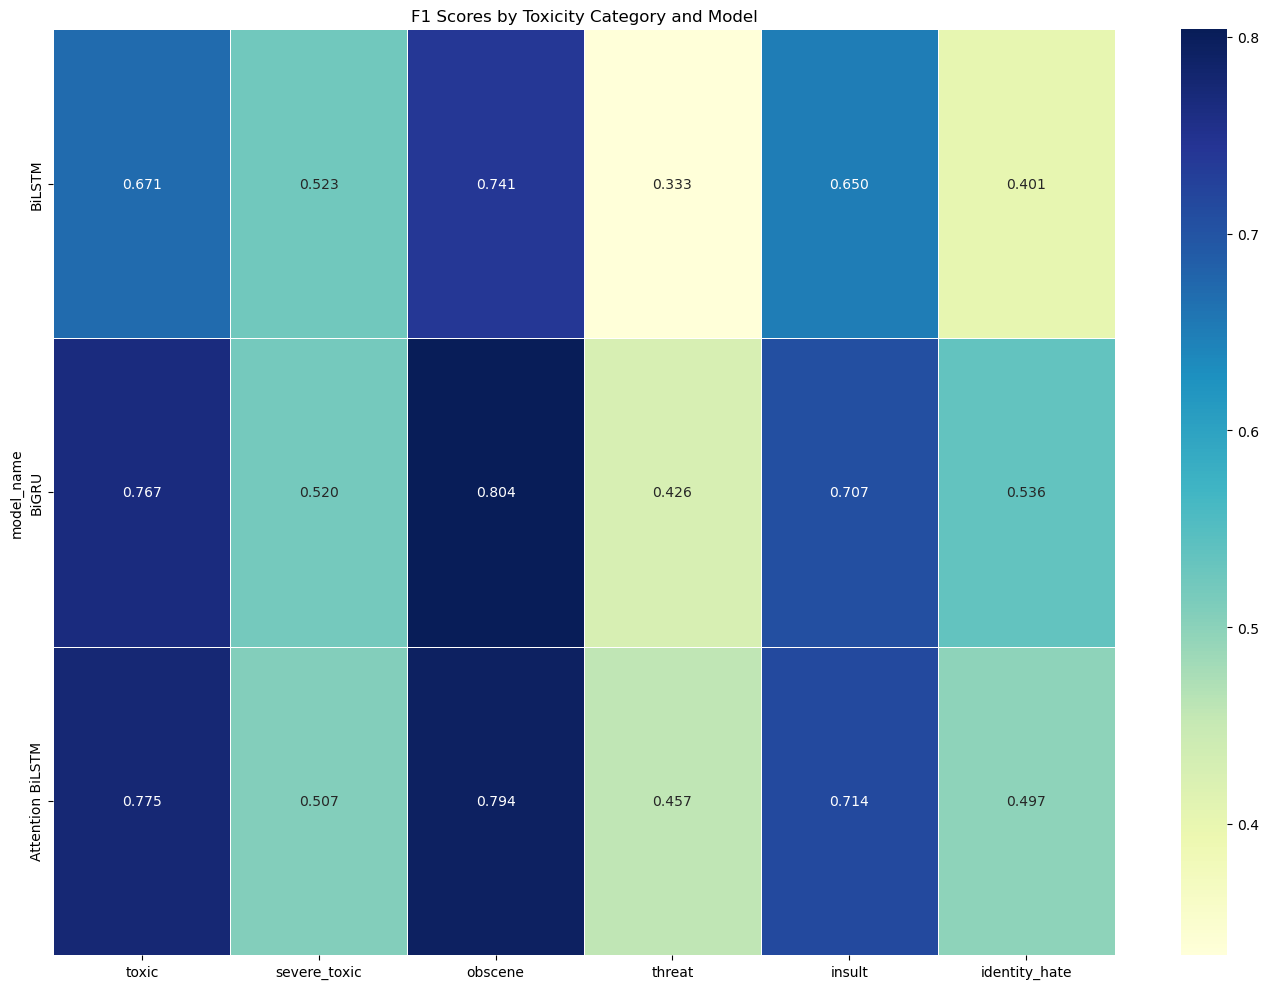

In [141]:
# Create a heatmap to compare F1 scores across toxicity categories
category_cols = [col for col in combined_df.columns if col.startswith('f1_')]
heatmap_df = combined_df[['model_name'] + category_cols].copy()
heatmap_df.columns = ['model_name'] + [col.split('_', 1)[1] for col in category_cols]
heatmap_df = heatmap_df.set_index('model_name')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5)
plt.title('F1 Scores by Toxicity Category and Model')
plt.tight_layout()
plt.savefig("../results/toxicity_category_heatmap.png")
plt.show()

## 9. Model Deployment for Inference

In [153]:
class ToxicCommentPredictor:
    def __init__(self, model_path, vocab, device='cpu', model_type=None):
        self.device = torch.device(device)
        self.vocab = vocab
        
        # Determine model type from path or explicit parameter
        if model_type is not None:
            model_type = model_type.lower()
        elif 'bilstm' in model_path.lower():
            model_type = 'lstm'
        elif 'gru' in model_path.lower():
            model_type = 'gru'
        elif 'attn' in model_path.lower():
            model_type = 'attn'
        else:
            # Default to LSTM if not specified
            model_type = 'lstm'
            print(f"Warning: Could not determine model type from path, defaulting to {model_type}")
        
        # Initialize the appropriate model architecture
        if model_type == 'lstm':
            self.model = LSTMClassifier(
                vocab_size=len(vocab),
                embedding_dim=EMBEDDING_DIM,
                hidden_dim=HIDDEN_DIM,
                output_dim=OUTPUT_DIM,
                n_layers=N_LAYERS,
                bidirectional=BIDIRECTIONAL,
                dropout=0.0,  # No dropout during inference
                pad_idx=PAD_IDX
            )
        elif model_type == 'gru':
            self.model = GRUClassifier(
                vocab_size=len(vocab),
                embedding_dim=EMBEDDING_DIM,
                hidden_dim=HIDDEN_DIM,
                output_dim=OUTPUT_DIM,
                n_layers=N_LAYERS,
                bidirectional=BIDIRECTIONAL,
                dropout=0.0,  # No dropout during inference
                pad_idx=PAD_IDX
            )
        elif model_type == 'attn':
            self.model = AttentionBiLSTM(
                vocab_size=len(vocab),
                embedding_dim=EMBEDDING_DIM,
                hidden_dim=HIDDEN_DIM,
                output_dim=OUTPUT_DIM,
                n_layers=N_LAYERS,
                dropout=0.0,  # No dropout during inference
                pad_idx=PAD_IDX
            )
        else:
            raise ValueError(f"Unknown model type: {model_type}")
            
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        self.label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    
    def predict(self, text):
        """
        Predict toxicity probabilities for a single text input
        
        Args:
            text (str): The input text to classify
            
        Returns:
            dict: Dictionary with prediction results including probabilities and binary decisions
        """
        # Preprocess input text
        numericalized_text = self.vocab.numericalize(text)
        input_tensor = torch.LongTensor(numericalized_text).unsqueeze(0).to(self.device)
        
        # Get model prediction
        self.model.eval()
        with torch.no_grad():
            output = self.model(input_tensor)
        
        # Convert to numpy for easier handling
        probs = output.squeeze().cpu().numpy()
        
        # Create dictionary of probabilities by label
        probabilities = {label: float(prob) for label, prob in zip(self.label_names, probs)}
        
        # Determine if the text is toxic (if any toxicity type is above 0.5)
        is_toxic = any(prob > 0.5 for prob in probs)
        
        return {
            'probabilities': probabilities,
            'is_toxic': is_toxic,
            'raw_predictions': probs
        }
    

In [154]:
# Save the vocabulary
with open('../models/rnn_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# Create a predictor instance with the correct model type
# Change from 'lstm' to 'attn' since the saved model appears to be an Attention BiLSTM
predictor = ToxicCommentPredictor('../models/best_rnn_model.pt', vocab, device=device, model_type='attn')

In [156]:
# Test the predictor with some example comments
example_texts = [
    "This is a positive comment. I really appreciate your help.",
    "You are an idiot and should not be allowed to post here.",
    "This is neutral content that has no emotional charge.",
    "You are a fucking disgrace."
]

for text in example_texts:
    print(f"\nInput: {text}")
    result = predictor.predict(text)
    print(f"Is toxic: {result['is_toxic']}")
    print("Toxicity probabilities:")
    for label, prob in result['probabilities'].items():
        print(f"  {label}: {prob:.4f}")


Input: This is a positive comment. I really appreciate your help.
Is toxic: False
Toxicity probabilities:
  toxic: 0.0497
  severe_toxic: 0.0086
  obscene: 0.0235
  threat: 0.0085
  insult: 0.0215
  identity_hate: 0.0406

Input: You are an idiot and should not be allowed to post here.
Is toxic: True
Toxicity probabilities:
  toxic: 0.7025
  severe_toxic: 0.2291
  obscene: 0.5231
  threat: 0.0590
  insult: 0.5079
  identity_hate: 0.2635

Input: This is neutral content that has no emotional charge.
Is toxic: False
Toxicity probabilities:
  toxic: 0.0596
  severe_toxic: 0.0115
  obscene: 0.0299
  threat: 0.0093
  insult: 0.0283
  identity_hate: 0.0528

Input: You are a fucking disgrace.
Is toxic: True
Toxicity probabilities:
  toxic: 0.9354
  severe_toxic: 0.6077
  obscene: 0.8962
  threat: 0.2234
  insult: 0.7943
  identity_hate: 0.4179


## 10. Save All Model Architecture Info and Results

In [144]:
# Create a dictionary with model architectures and hyperparameters
model_info = {
    'BiLSTM': {
        'type': 'LSTM',
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'n_layers': N_LAYERS,
        'bidirectional': BIDIRECTIONAL,
        'dropout': DROPOUT,
        'vocab_size': vocab_size,
        'learning_rate': LEARNING_RATE,
        'epochs': N_EPOCHS
    },
    'BiGRU': {
        'type': 'GRU',
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'n_layers': N_LAYERS,
        'bidirectional': BIDIRECTIONAL,
        'dropout': DROPOUT,
        'vocab_size': vocab_size,
        'learning_rate': LEARNING_RATE,
        'epochs': N_EPOCHS
    },
    'Attention BiLSTM': {
        'type': 'Attention BiLSTM',
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'n_layers': N_LAYERS,
        'bidirectional': True,  # Always bidirectional for this model
        'dropout': DROPOUT,
        'vocab_size': vocab_size,
        'learning_rate': LEARNING_RATE,
        'epochs': N_EPOCHS
    }
}

# Save the model information
with open('../models/rnn_model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

In [157]:
# Create a summary dictionary for easy comparison
summary = {
    'model_comparison': combined_df[['model_name', 'accuracy', 'macro_f1', 'micro_f1']].sort_values('macro_f1', ascending=False).to_dict('records'),
    'best_model': combined_df.loc[combined_df['macro_f1'].idxmax()]['model_name'],
    'model_info': model_info
}

# Save the summary
with open('../results/rnn_models_summary.pkl', 'wb') as f:
    pickle.dump(summary, f)

print(f"Best model: {summary['best_model']}")

Best model: BiGRU


## 11. Conclusion

In this notebook, we have:

1. Implemented three RNN architectures for toxic comment classification:
   - Bidirectional LSTM
   - Bidirectional GRU
   - Attention-based Bidirectional LSTM

2. Trained and evaluated each model on the toxic comment dataset

3. Compared the RNN models with previously trained traditional ML models

4. Created a simple inference system for making predictions on new text

5. Saved the models, their architectures, and evaluation results for future use

The RNN models, especially those with attention mechanisms, can capture sequential information in the text that traditional bag-of-words models like TF-IDF might miss, potentially improving the detection of complex toxic patterns.